In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2


In [4]:
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers

In [5]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Activation,AveragePooling2D ,ReLU ,Add,Dense,Reshape,Multiply, Dropout, UpSampling2D,Conv2D,MaxPooling2D,concatenate,add,GlobalAveragePooling2D,GlobalMaxPool2D,Multiply

In [6]:
train_images =np.load("D:/projects/Lane/image_mixed.npy").astype(np.float32)
labels = np.load("D:/projects/Lane/label_mixed.npy").astype(np.float32)
train_images = np.array(train_images)
labels = np.array(labels)
labels = labels / 255
train_images, labels = shuffle(train_images, labels)
X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.3)
batch_size =64
epochs = 100
pool_size = (2, 2)
input_shape = X_train.shape[1:]
y_train=y_train.reshape(y_train.shape[0],80,160,1)
y_val=y_val.reshape(y_val.shape[0],80,160,1)
print(y_val.shape)

(4500, 80, 160, 1)


In [7]:
import tensorflow.keras.backend as K

def dsc(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dsc(y_true, y_pred)



def IOU(y_true, y_pred):

    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)

    thresh = 0.5

    y_true = K.cast(K.greater_equal(y_true, thresh), 'float32')
    y_pred = K.cast(K.greater_equal(y_pred, thresh), 'float32')

    union = K.sum(K.maximum(y_true, y_pred)) + K.epsilon()
    intersection = K.sum(K.minimum(y_true, y_pred)) + K.epsilon()

    iou = intersection/union

    return iou

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [8]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50,MobileNetV2
def deconv(x, kernelsize,fi):
    #fi=x.shape[-1]
    fx = Conv2DTranspose(fi, kernelsize, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)
    fx =Conv2DTranspose(fi, kernelsize, padding='same')(fx)
    out = BatchNormalization()(fx)
    return out

In [9]:
def CBAM (x,r):
    
    ###### Channel Attention ##########
    f=x.shape[-1]
    a_pool = GlobalAveragePooling2D()(x)
    m_pool = GlobalMaxPool2D()(x) 
    Dense_layer1 = Dense (f // r , activation = 'relu') 
    Dense_layer2 = Dense (f, activation = 'relu') 
    avg_out = Dense_layer2 (Dense_layer1(a_pool)) 
    max_out = Dense_layer2 (Dense_layer1( m_pool))
    channel = add([ avg_out,max_out]) 
    channel = Activation('sigmoid') (channel) 
    channel = Reshape ((1,1,f)) (channel)  
    C_out = Multiply()([x,channel])
   
    
                      
    ###### Spatial Attention ########
    av_pooling=AveragePooling2D(pool_size=(1,1))(C_out)
    ma_pooling=MaxPooling2D(pool_size=(1,1))(C_out)
    spatial=concatenate([av_pooling,ma_pooling], axis = 3)
    spatial =Conv2D(1,(7,7),strides=1,padding ='same') (spatial) 
    #spatial=ASPP(x,spatial)
    
    spatial= Activation('sigmoid')(spatial)
      
    S_out = Multiply()([C_out,spatial])
    
    return S_out

In [10]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50,MobileNetV2
def resblock(x, kernelsize,fi):
    #fi=x.shape[-1]
    fx = Conv2D(fi, kernelsize, activation='relu', padding='same')(x)
    fx = BatchNormalization()(fx)
    fx =Conv2D(fi, kernelsize, padding='same')(fx)
    x=Conv2D(1,1, activation='relu', padding='same')(x)
    out = Add()([x,fx])
    out = ReLU()(out)
    out = BatchNormalization()(out)
    return out

In [11]:
inputs = keras.layers.Input((80,160,3))

block1=resblock(inputs,3,8)

pool1 = MaxPooling2D(pool_size=(2, 2),name="pool1")(block1)
    
block2=resblock(pool1,3,16)

pool2 = MaxPooling2D(pool_size=(2, 2),name="pool2")(block2)
    
block3=resblock(pool2,3,32)

pool3 = MaxPooling2D(pool_size=(2, 2),name="pool3")(block3)


block4=resblock(pool3,3,64)

pool4 = MaxPooling2D(pool_size=(2, 2),name="pool4")(block4)







a1=CBAM (pool1,8)

a2=CBAM (pool2,8)

a2=UpSampling2D(size = (2,2))(a2)
c1=concatenate([a1,a2], axis = 3)



a3=CBAM (pool3,8)

a4=CBAM (pool4,8)


a4=UpSampling2D(size = (2,2))(a4)
c2=concatenate([a3,a4], axis = 3)
c2=UpSampling2D(size = (2,2))(c2)








c1=UpSampling2D(size = (2,2))(c1)
D1=deconv(c1, 3,32)

c2=UpSampling2D(size = (4,4))(c2)
D2=deconv(c2, 3,16)


pool4=UpSampling2D(size = (16,16))(pool4)
D3=deconv(pool4, 3,8)




D=concatenate([D1,D2,D3], axis = 3)


O= Conv2DTranspose(1, 1, activation = 'sigmoid')(D)
model = Model(inputs, O)
datagen = ImageDataGenerator(channel_shift_range=0.2)
datagen.fit(X_train)
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,  loss = "binary_crossentropy", metrics = ['dsc','accuracy', 'IOU','precision_m', 'recall_m', 'f1_m'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 160, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 80, 160, 8)   224         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 160, 8)  32          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [12]:
model.save('D:/projects/Lane/LLDNet.h5')

In [13]:
from tensorflow.keras.models import load_model
 
# load model
model = load_model('D:/projects/Lane/LLDNet.h5',custom_objects={'dice_loss':dice_loss,'IOU':IOU,'dsc':dsc,'precision_m':precision_m, 'recall_m':recall_m, 'f1_m':f1_m})
# summarize model.

In [14]:
history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
epochs=epochs, verbose=1, validation_data=(X_val, y_val))

model.save('D:/projects/Lane/LLDNet.h5')

Epoch 1/100


C:\Users\Khan\AppData\Local\Temp\ipykernel_10020\473441665.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,


164/164 [==============================] - 21s 82ms/step - loss: 0.1354 - dsc: 0.8379 - accuracy: 0.9285 - IOU: 0.8465 - precision_m: 0.8942 - recall_m: 0.9274 - f1_m: 0.9048 - val_loss: 0.1177 - val_dsc: 0.7976 - val_accuracy: 0.9521 - val_IOU: 0.8984 - val_precision_m: 0.9586 - val_recall_m: 0.9185 - val_f1_m: 0.9381
Epoch 2/100
164/164 [==============================] - 12s 72ms/step - loss: 0.0509 - dsc: 0.9349 - accuracy: 0.9567 - IOU: 0.9271 - precision_m: 0.9639 - recall_m: 0.9504 - f1_m: 0.9569 - val_loss: 0.0501 - val_dsc: 0.9228 - val_accuracy: 0.9569 - val_IOU: 0.9242 - val_precision_m: 0.9783 - val_recall_m: 0.9327 - val_f1_m: 0.9549
Epoch 3/100
164/164 [==============================] - 12s 72ms/step - loss: 0.0407 - dsc: 0.9464 - accuracy: 0.9587 - IOU: 0.9389 - precision_m: 0.9678 - recall_m: 0.9579 - f1_m: 0.9627 - val_loss: 0.0391 - val_dsc: 0.9476 - val_accuracy: 0.9590 - val_IOU: 0.9411 - val_precision_m: 0.9707 - val_recall_m: 0.9564 - val_f1_m: 0.9635
Epoch 4/100
1

In [15]:
train_loss = history.history['loss']
valid_loss = history.history['val_loss']

train_acc = history.history['accuracy']
valid_acc = history.history['val_accuracy']

In [16]:
from numpy import savetxt
savetxt('train_loss_LLD.csv', train_loss, delimiter=',')
savetxt('valid_loss_LLD.csv', valid_loss, delimiter=',')

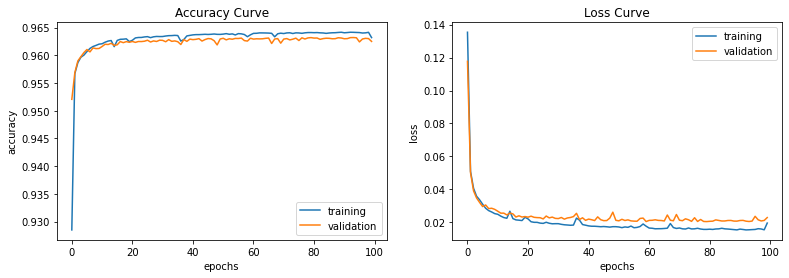

In [18]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(13,4))
axes = axes.flatten()

axes[0].plot(train_acc, label='training')
axes[0].plot(valid_acc, label='validation')
axes[0].set_title('Accuracy Curve')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('accuracy')
axes[0].legend()


axes[1].plot(train_loss, label='training')
axes[1].plot(valid_loss, label='validation')
axes[1].set_title('Loss Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('loss')
axes[1].legend()

plt.show()

In [19]:
train_dice = history.history['dsc']
valid_dice = history.history['val_dsc']


train_IOU = history.history['IOU']
valid_IOU = history.history['val_IOU']

In [20]:
from numpy import savetxt
savetxt('train_dice_LLD.csv', train_dice, delimiter=',')
savetxt('valid_dice_LLD.csv', valid_dice, delimiter=',')

savetxt('train_IOU_LLD.csv', train_IOU, delimiter=',')
savetxt('valid_IOU_LLD.csv', valid_IOU, delimiter=',')

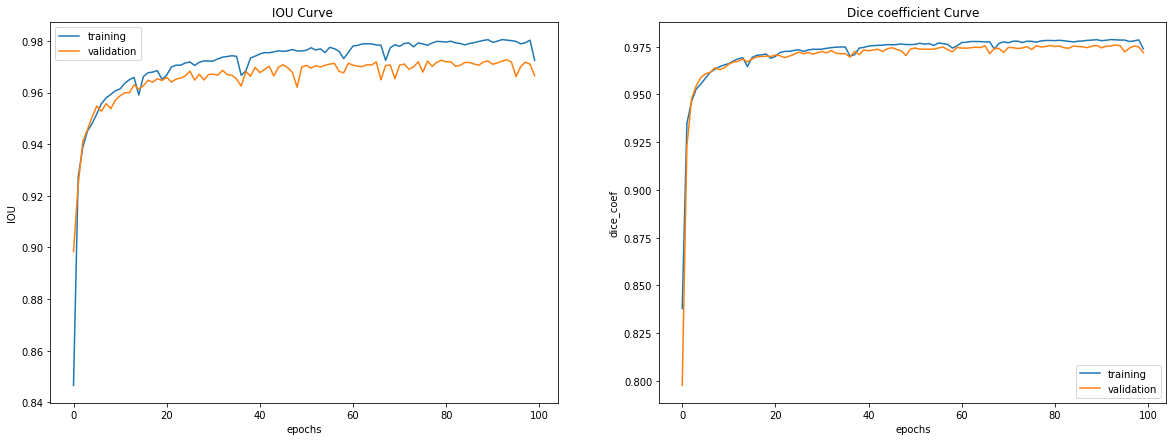

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(20,7))
axes = axes.flatten()

axes[0].plot(train_IOU, label='training')
axes[0].plot(valid_IOU, label='validation')
axes[0].set_title('IOU Curve ')
axes[0].set_xlabel('epochs')
axes[0].set_ylabel('IOU')
axes[0].legend()


axes[1].plot(train_dice, label='training')
axes[1].plot(valid_dice, label='validation')
axes[1].set_title('Dice coefficient Curve')
axes[1].set_xlabel('epochs')
axes[1].set_ylabel('dice_coef')
axes[1].legend()

plt.show()